# Causal Graph Creation, Identification, and Estimation

This notebook reviews how to go from a DAG with both latent and observed nodes, and reduce it into a DAG with latent confounders.

Psudeo-code of the final algorithm is as follows:

```
G: full graph with latent nodes
H: subset graph of observed nodes

graph_builder(G, H):
    
    latent_edges = list()
    node_pairs = H.edges()

    for pair in node_pairs:

        # find common ancestor
        confounder = lowest_common_ancestor(G, pair[0], pair[1])
        if confounder is not Null:
            path1 = shorest_path(confounder, pair[0])
            path2 = shorest_path(confounder, pair[1])

            if all(path1, latent) & all(path2, latent):
                latent_edges.append(pair[0], pair[1])
     
    
```

We will prove this works through cases. All cases are outlined below. Each is fit with an SCM and the reduced graph is proven to be equivalent to the full graph.

Python version of code:

In [683]:
H = remove_latent_nodes(G, ["U"])

In [ ]:
graph_builder(G, 

In [685]:
node_pairs = list(H.edges())

In [686]:
node_pairs

[('X', 'Z'), ('Z', 'Y')]

In [687]:
temp_G = G.copy()

In [688]:
pair = ('X', 'Z')

In [689]:
path = nx.shortest_path(temp_G, pair[0], pair[1])

In [690]:
path

['X', 'Z']

In [691]:
temp_G.remove_edge(path[0], path[1])

In [692]:
path = nx.shortest_path(temp_G, pair[0], pair[1])

NetworkXNoPath: No path between X and Z.

In [693]:
confounder = nx.lowest_common_ancestor(temp_G, pair[0], pair[1], default= None)

In [694]:
confounder

In [ ]:
def graph_builder(G, H):
    
    """
    Function to determine latent edges of a DAG. Requires two graphs. The first a 
    full graph with both the latent and observed nodes. The second a reduced graph 
    with only the observed graphs. The function then compares the graphs and 
    determines where to add the latent edges.
    
    Parameters
    ----------
    G : networkx.DiGraph
        A full graph with both latent and observed nodes
    H : networkx.DiGraph
        A reduced graph with only observed nodes
        
    Returns
    -------
    y0.graph.NxMixedGraph
        A y0 graph which includes observed nodes and latent confounders
    """
    
    latent_edges = list()
    node_pairs = list(H.edges())

    for pair in node_pairs:
        
        temp_G = G.copy()
        
        ## Always break an edge to prevent lowest_common_ancestor from returning itself
        try:
            path = nx.shortest_path(temp_G, pair[0], pair[1])
        except:
            path = None
        while path != None:
            temp_G.remove_edge(path[0], path[1])
            try:
                path = nx.shortest_path(temp_G, pair[0], pair[1])
            except:
                path = None
        
        # find common ancestor
        confounder = nx.lowest_common_ancestor(temp_G, pair[0], pair[1], default= None)

        if confounder != None:
            path1 = nx.shortest_path(temp_G, confounder, pair[0])
            path1 = [i for i in path1 if i != pair[0]]
            path2 = nx.shortest_path(temp_G, confounder, pair[1])
            path2 = [i for i in path2 if i != pair[1]]
            
            if (not any([H.has_node(i) for i in path1])) & (not any([H.has_node(i) for i in path2])):
                latent_edges.append((pair[0], pair[1]))
    napkin = NxMixedGraph.from_str_edges(directed = list(H.edges),
                                     undirected = latent_edges)

    return napkin
     

## Imports and functions

In [1]:
import pandas as pd
import numpy as np
import pickle
import itertools

from protmapper import uniprot_client
from scipy.stats import linregress

from dowhy import gcm

import networkx as nx
from y0.graph import NxMixedGraph
from y0.identify import is_identifiable
from y0.algorithm.identify import Identification
from y0.dsl import P, X, Y, Variable, Z, U

import matplotlib.pyplot as plt
%matplotlib inline

## TODO: Build out linear regression simulator for identifiability confirmation
def gen_data(graph):
    
    """
    Generate simulated data for a provided full networkx graph.
    """
    
    for edge in graph.edges():
        list(G.edges())

def fit_scm(graph, data, intervention, target):
    
    """
    Fits an
    """
    
    causal_model = gcm.StructuralCausalModel(graph)
    gcm.auto.assign_causal_mechanisms(causal_model, data)
    gcm.fit(causal_model, data)

    effect = gcm.average_causal_effect(causal_model,
                             target,
                             interventions_alternative={intervention: lambda y: 1},
                             interventions_reference={intervention: lambda y: 0},
                             num_samples_to_draw=1000)
    
    
    return effect

def remove_latent_nodes(G, latent_nodes):
    g = G.copy()

    for i in range(len(latent_nodes)):

        g0 = g.copy()
        for node, degree in g.degree():
            ## only remove latent nodes
            if node == latent_nodes[i]:
                
                ## grab edges
                in_edge = list(g0.in_edges(node))
                out_edge = list(g0.out_edges(node))
                
                ## Dump node and fully reconnect edges
                g0.remove_node(node)
                for in_e in range(len(in_edge)):
                    for out_e in range(len(out_edge)):
                        g0.add_edge(in_edge[in_e][0], out_edge[out_e][1])
        g = g0
    
    for node, degree in g.degree():
        g1 = g.copy()
        if degree == 0:
            g1.remove_node(node)
        g = g1
    return g

def find_all_identifiable_pairs(G):
    
    identify = list()
    not_identify = list()
    for pair in itertools.combinations(y0_graph.nodes(), r=2):
        is_ident = is_identifiable(y0_graph, P(pair[0] @ pair[1]))
        is_ident_opp = is_identifiable(y0_graph, P(pair[1] @ pair[0]))
        if is_ident:
            identify.append((pair[0], pair[1]))
        else:
            not_identify.append((pair[0], pair[1]))
        if is_ident_opp:
            identify.append((pair[1], pair[0]))
        else:
            not_identify.append((pair[1], pair[0]))
    
    return {"Identifiable" : identify,
            "NonIdentifiable" : not_identify}

def identify_queries_of_interest(G, data, identifiable_queries, abs_filter=95):
    
    causal_model = gcm.StructuralCausalModel(G)
    gcm.auto.assign_causal_mechanisms(causal_model, data)
    gcm.fit(causal_model, data)
    
    ace_pairs = dict()
    lm_coef = dict()
    
    for pair in identifiable_queries:
        ## TODO: Figure out why some queries fail (backwards queries maybe?)
        try:
            effect = gcm.average_causal_effect(causal_model,
                             str(pair[1]),
                             interventions_alternative={str(pair[0]): lambda y: 1},
                             interventions_reference={str(pair[0]): lambda y: 0},
                             num_samples_to_draw=1000)
            ace_pairs["{0}-{1}".format(pair[0], pair[1])] = effect

            model = linregress(data[str(pair[0])], data[str(pair[1])])
            lm_coef["{0}-{1}".format(pair[0], pair[1])] = model.slope

        except:
            pass
        #     print("{0}-{1} Could not be estimated".format(pair[0], pair[1]))
            
    diff = dict()
    for key in ace_pairs.keys():
        diff[key] = abs(ace_pairs[key] - lm_coef[key])
    
    sorted_dif = sorted(diff.items(), key=lambda item: item[1], reverse=True)
    
    high_ace = np.percentile(np.abs(list(ace_pairs.values())), abs_filter)

    pairs_to_keep = [sorted_dif[i] for i in range(len(sorted_dif)) if abs(ace_pairs[sorted_dif[i][0]]) > high_ace]
    
    return {"ace_pairs" : ace_pairs, "lm_coef" : lm_coef, "pairs_to_keep" : pairs_to_keep}

def plot_latent_graph(y0, figure_size=(4,3)):
    temp_G = nx.DiGraph()

    for d_edge in list(y0.directed.edges):
        temp_G.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0.undirected.edges):
        if temp_G.has_edge(u_edge[0], u_edge[1]):
            temp_G.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_G.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    pos=nx.spring_layout(temp_G)
    edges = temp_G.edges()
    colors = [temp_G[u][v]['color'] for u,v in edges]
    styles = [temp_G[u][v]['style'] for u,v in edges]
    arrowsizes = [temp_G[u][v]['size'] for u,v in edges]

    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_G, pos=pos, node_size=1000, margins=[.1,.1], alpha=.7)
    nx.draw_networkx_labels(temp_G, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_G, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1', 
                           edge_color=colors, width = 3, style=styles, arrowsize=arrowsizes)
    # ax.patches[0]

## Cases

#### Base Case: Two observed nodes, connected with one edge.

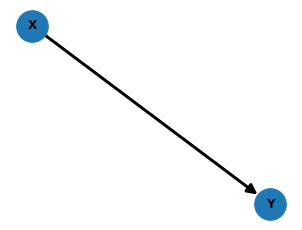

In [202]:
G = nx.DiGraph()
G.add_edge("X","Y")
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [203]:
X_data = np.random.normal(loc=1, scale=1, size=1000)
Y_data = 2 * X_data + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X_data, Y=Y_data))

fit_scm(G, data, "X", "Y")

Fitting causal mechanism of node Y: 100%|████████████████████████████████████████████████| 2/2 [00:00<00:00, 505.49it/s]


#### Case 1: One latent confounder

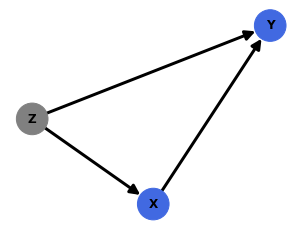

In [221]:
G = nx.DiGraph()
G.add_edge("X","Y")
G.add_edge("Z","X")
G.add_edge("Z","Y")
color_map = ["royalblue" if node != "Z" else "grey" for node in G]
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

##### Test identifiability

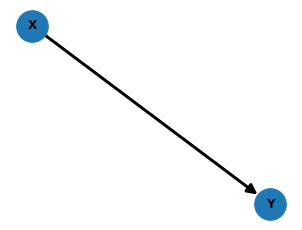

In [224]:
H = G.subgraph(["X", "Y"])
plt.figure(figsize=(4,3))
nx.draw(H, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [225]:
y0_graph = graph_builder(G, H)
is_identifiable(y0_graph, P(Y @ ~X))

False

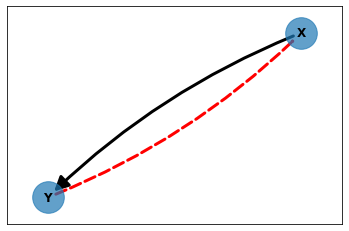

In [226]:
plot_latent_graph(y0_graph)

##### Confirm with SCM

In [227]:
Z_data = np.random.normal(loc=1, scale=1, size=1000)
X_data = 2 * Z_data + np.random.normal(loc=0, scale=1, size=1000)
Y_data = 2 * X_data + 2 * Z_data + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X_data, Y=Y_data))

fit_scm(H, data, "X", "Y")

Fitting causal mechanism of node Y: 100%|████████████████████████████████████████████████| 2/2 [00:00<00:00, 587.19it/s]


#### Case 2: Two latent confounders

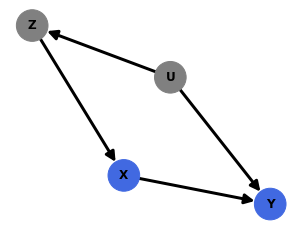

In [228]:
G = nx.DiGraph()
G.add_edge("X","Y")
G.add_edge("Z","X")
G.add_edge("U", "Z")
G.add_edge("U","Y")
color_map = ["royalblue" if node not in ["Z", "U"] else "grey" for node in G]
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

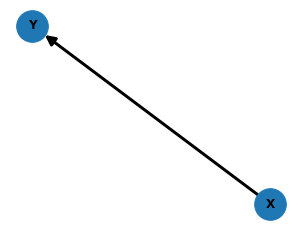

In [229]:
H = G.subgraph(["X", "Y"])
plt.figure(figsize=(4,3))
nx.draw(H, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [230]:
y0_graph = graph_builder(G, H)
y0_graph.undirected.edges

EdgeView([(X, Y)])

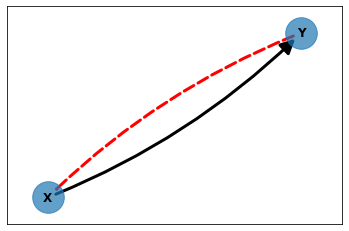

In [231]:
plot_latent_graph(y0_graph)

##### Test identifiability

In [232]:
is_identifiable(y0_graph, P(Y @ ~X))

False

In [233]:
U_data = np.random.normal(loc=1, scale=1, size=1000)
Z_data = 3 * U_data + np.random.normal(loc=1, scale=1, size=1000)
X_data = 2 * Z_data + np.random.normal(loc=0, scale=1, size=1000)
Y_data = 2 * X_data + 2 * U_data + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X_data, Y=Y_data))

fit_scm(H, data, "X", "Y")

Fitting causal mechanism of node Y: 100%|████████████████████████████████████████████████| 2/2 [00:00<00:00, 511.03it/s]


#### Case 3: Observed node upstream

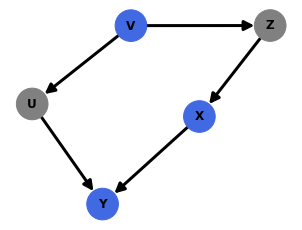

In [234]:
G = nx.DiGraph()
G.add_edge("X","Y")
G.add_edge("Z","X")
G.add_edge("V", "U")
G.add_edge("V", "Z")
G.add_edge("U","Y")
color_map = ["royalblue" if node not in ["Z", "U"] else "grey" for node in G]
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

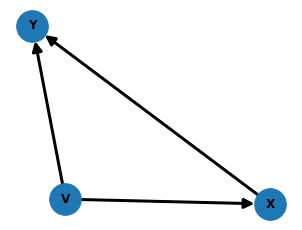

In [235]:
H = remove_latent_nodes(G, ["U", "Z"])

plt.figure(figsize=(4,3))
nx.draw(H, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [236]:
y0_graph = graph_builder(G, H)
y0_graph.undirected.edges

EdgeView([])

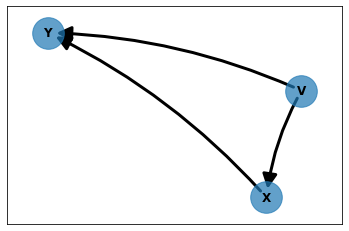

In [237]:
plot_latent_graph(y0_graph)

##### Test identifiability

In [238]:
is_identifiable(y0_graph, P(Y @ ~Variable("X")))

True

In [239]:
V_data = np.random.normal(loc=1, scale=1, size=1000)
Z_data = V_data + np.random.normal(loc=0, scale=1, size=1000)
U_data = V_data + np.random.normal(loc=0, scale=1, size=1000)
X_data = Z_data + np.random.normal(loc=0, scale=1, size=1000)
Y_data = U_data + X_data + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X_data, Y=Y_data,V=V_data))

fit_scm(H, data, "X", "Y")

Fitting causal mechanism of node V: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 371.50it/s]


#### Case 4: Observed node upstream, but latent confounder as well

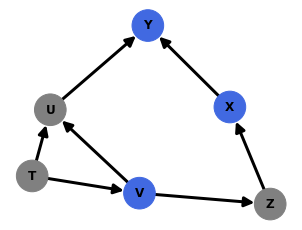

In [240]:
G = nx.DiGraph()
G.add_edge("X","Y")
G.add_edge("Z","X")
G.add_edge("V", "U")
G.add_edge("V", "Z")
G.add_edge("U","Y")
G.add_edge("T", "V")
G.add_edge("T", "U")

color_map = ["royalblue" if node not in ["Z", "U", "T"] else "grey" for node in G]
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

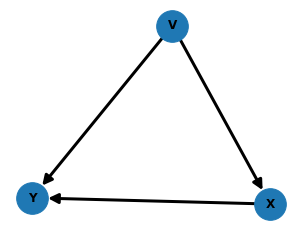

In [241]:
H = remove_latent_nodes(G, ["U", "Z", "T"])

plt.figure(figsize=(4,3))
nx.draw(H, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [242]:
y0_graph = graph_builder(G, H)
y0_graph.undirected.edges

EdgeView([(Y, V)])

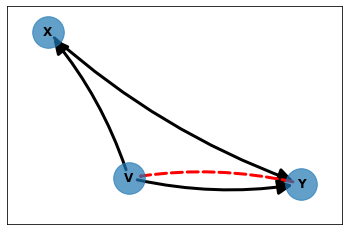

In [243]:
plot_latent_graph(y0_graph)

In [244]:
is_identifiable(y0_graph, P(Y @ ~Variable("X")))

True

In [245]:
T_data = np.random.normal(loc=1, scale=1, size=1000)
V_data = T_data + np.random.normal(loc=0, scale=1, size=1000)
Z_data = V_data + np.random.normal(loc=0, scale=1, size=1000)
U_data = V_data + T_data + np.random.normal(loc=0, scale=1, size=1000)
X_data = Z_data + np.random.normal(loc=0, scale=1, size=1000)
Y_data = U_data + X_data + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X_data, Y=Y_data,V=V_data))

fit_scm(H, data, "X", "Y")

Fitting causal mechanism of node V: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 428.37it/s]


#### Case 5: Latent causal path around observed nodes

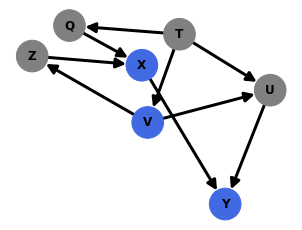

In [246]:
G = nx.DiGraph()
G.add_edge("X","Y")
G.add_edge("Z","X")
G.add_edge("V", "U")
G.add_edge("V", "Z")
G.add_edge("U","Y")
G.add_edge("T", "V")
G.add_edge("T", "U")
G.add_edge("T", "Q")
G.add_edge("Q", "X")

color_map = ["royalblue" if node not in ["Z", "U", "T", "Q"] else "grey" for node in G]
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

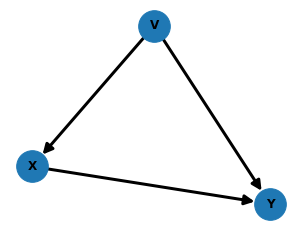

In [247]:
H = remove_latent_nodes(G, ["U", "Z", "T", "Q"])

plt.figure(figsize=(4,3))
nx.draw(H, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [248]:
y0_graph = graph_builder(G, H)
y0_graph.undirected.edges

EdgeView([(X, V), (Y, V)])

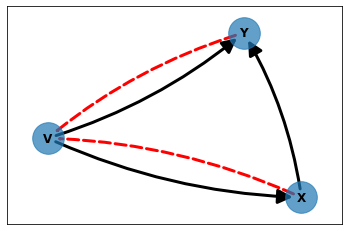

In [249]:
plot_latent_graph(y0_graph)

In [42]:
is_identifiable(y0_graph, P(Y @ ~Variable("X")))

False

In [43]:
T_data = np.random.normal(loc=1, scale=1, size=1000)
V_data = T_data + np.random.normal(loc=0, scale=1, size=1000)
Z_data = V_data + np.random.normal(loc=0, scale=1, size=1000)
U_data = V_data + T_data + np.random.normal(loc=0, scale=1, size=1000)
X_data = Z_data + np.random.normal(loc=0, scale=1, size=1000)
Y_data = U_data + X_data + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X_data, Y=Y_data,V=V_data))

fit_scm(H, data, "X", "Y")

Fitting causal mechanism of node V: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 454.63it/s]


#### Case 6: Lower latent confounder between X and Y

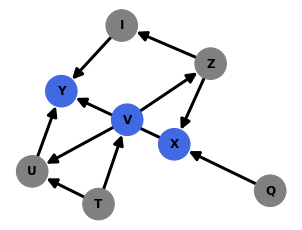

In [805]:
G = nx.DiGraph()
G.add_edge("X","Y")
G.add_edge("Z","X")
G.add_edge("V", "U")
G.add_edge("V", "Z")
G.add_edge("U","Y")
G.add_edge("T", "V")
G.add_edge("T", "U")
G.add_edge("Q", "X")
G.add_edge("Z", "I")
G.add_edge("I", "Y")

color_map = ["royalblue" if node not in ["Z", "U", "T", "Q", "I"] else "grey" for node in G]
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

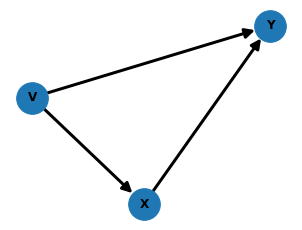

In [251]:
H = remove_latent_nodes(G, ["Z", "U", "T", "Q", "I"])
plt.figure(figsize=(4,3))
nx.draw(H, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [252]:
y0_graph = graph_builder(G, H)
y0_graph.undirected.edges

EdgeView([(X, Y), (Y, V)])

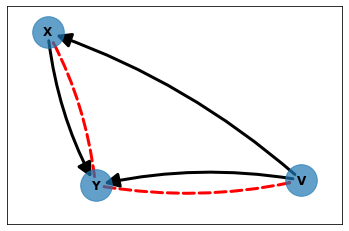

In [254]:
plot_latent_graph(y0_graph)

In [31]:
is_identifiable(y0_graph, P(Y @ ~Variable("X")))

False

## Full transcription network

In [255]:
G = nx.drawing.nx_pydot.read_dot("Full_TF_network.dot")
with open('latent_nodes.pickle', 'rb') as handle:
    latent_nodes = pickle.load(handle)

In [256]:
G.remove_edge("FOXO1", "IRF4")
G.remove_edge("FOXO1", "MYC")
G.remove_edge("PRDM1", "MYC")
G.remove_edge("DNMT1", "STAT3")

G = nx.DiGraph(G)

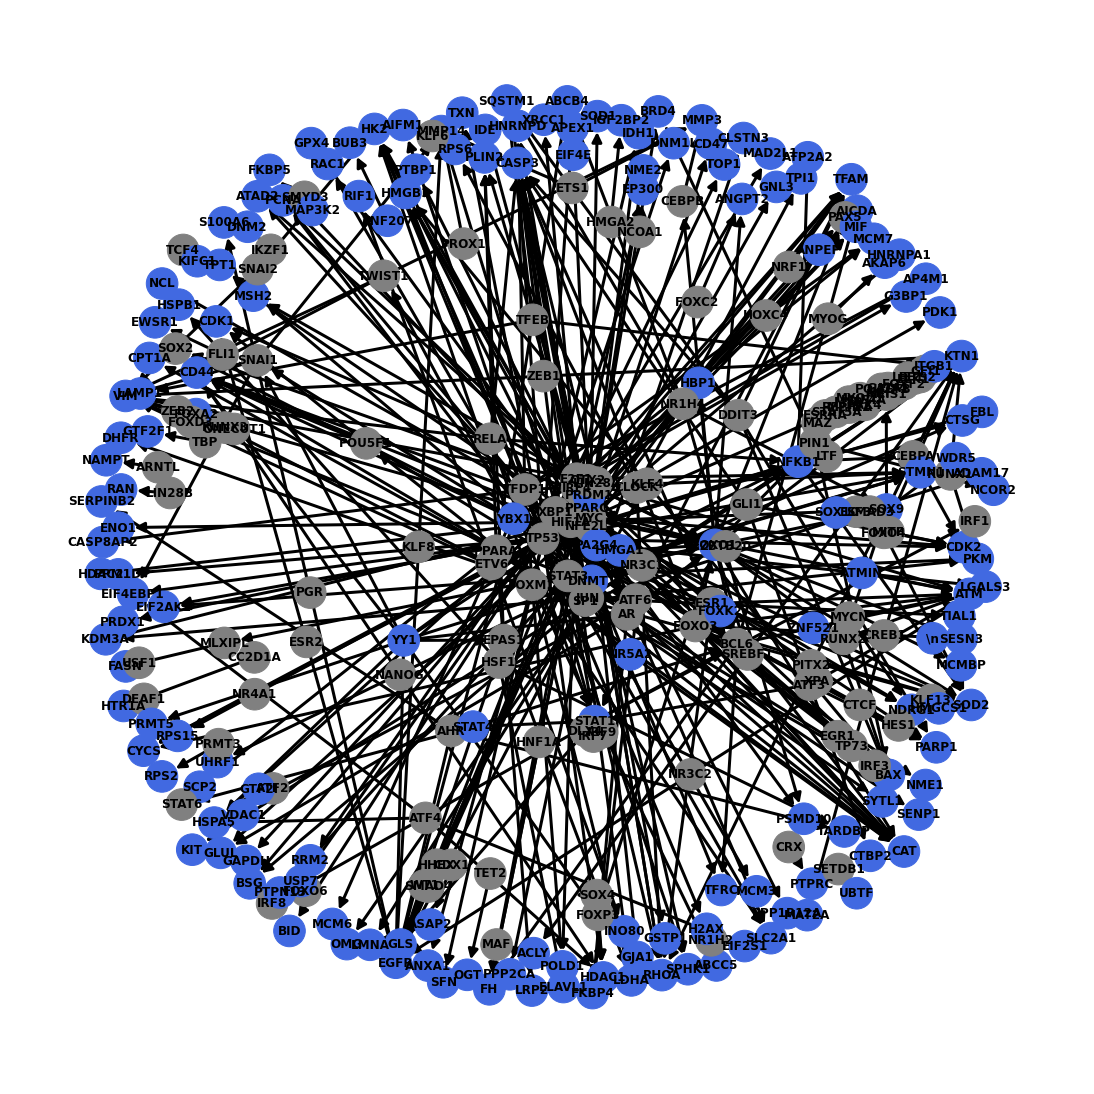

In [257]:
color_map = ["royalblue" if node not in latent_nodes else "grey" for node in G]
plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

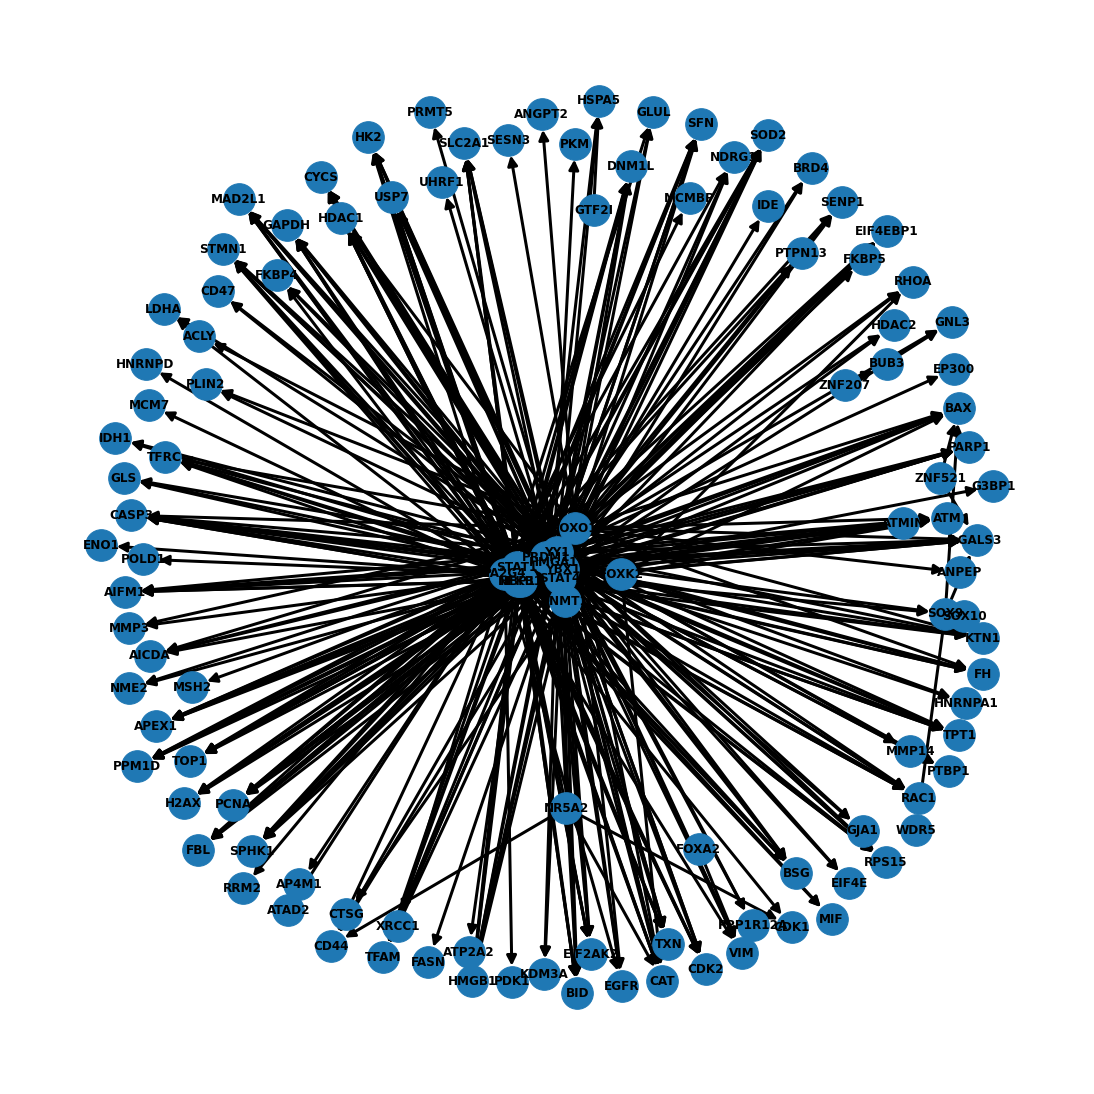

In [258]:
H = remove_latent_nodes(G, latent_nodes)
plt.figure(figsize=(15,15))
nx.draw(H, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [259]:
y0_graph = graph_builder(G, H)

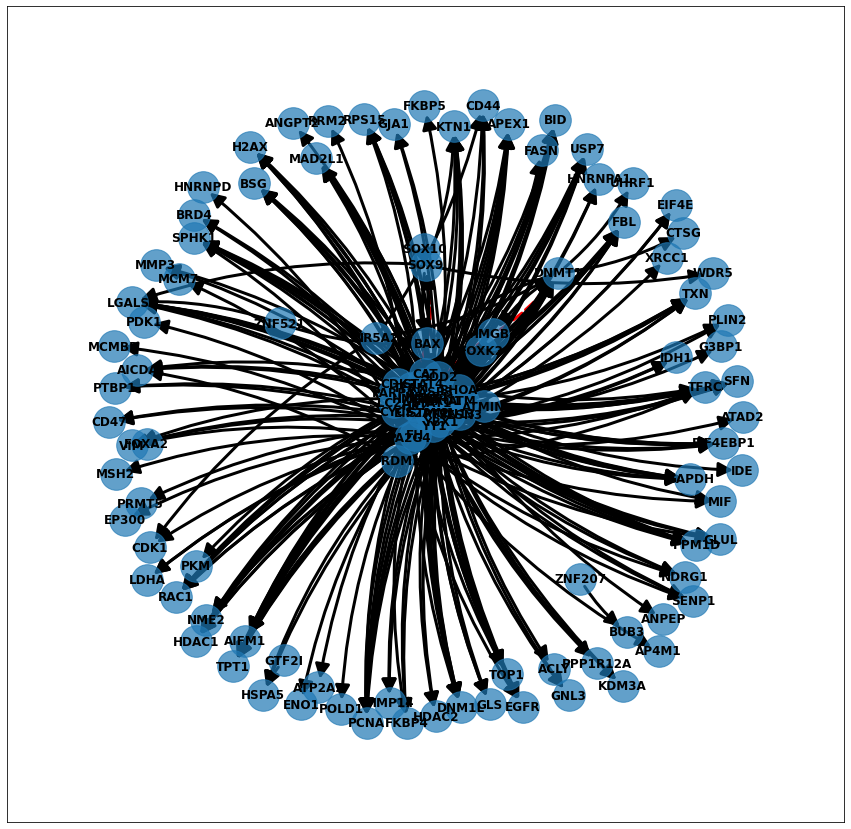

In [265]:
plot_latent_graph(y0_graph, figure_size=(15,15))

In [49]:
queries = find_all_identifiable_pairs(y0_graph)

In [51]:
mel = pd.read_csv("../Data/Leduc/MS_results_data/Melanoma_cells.csv")
mel.drop(columns="id", inplace=True)
mel.columns = np.array([uniprot_client.get_gene_name(x) for x in mel.columns])

mon = pd.read_csv("../Data/Leduc/MS_results_data/Monocyte_cells.csv")
mon.drop(columns="id", inplace=True)
mon.columns = np.array([uniprot_client.get_gene_name(x) for x in mon.columns])

In [291]:
mel_interventions = identify_queries_of_interest(H, mel, queries['Identifiable'], abs_filter=90)
mon_interventions = identify_queries_of_interest(H, mon, queries['Identifiable'], abs_filter=90)

Fitting causal mechanism of node STAT4: 100%|█████████████████████████████████████████| 116/116 [00:05<00:00, 23.01it/s]


ACE : -0.28
LM Coef : -0.04


Text(0, 0.5, 'GAPDH')

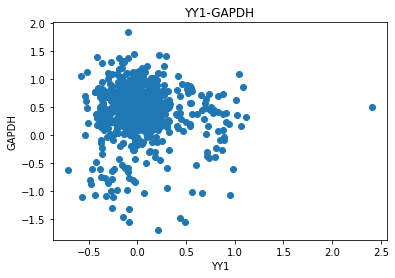

In [295]:
top_mel = mel_interventions["pairs_to_keep"][1]
print("ACE : {0}".format(str(round(mel_interventions["ace_pairs"][top_mel[0]], 2))))
print("LM Coef : {0}".format(str(round(mel_interventions["lm_coef"][top_mel[0]], 2))))

fig, ax = plt.subplots()
ax.scatter(mel[top_mel[0].split("-")[0]], mel[top_mel[0].split("-")[1]])
ax.set_title(top_mel[0])
ax.set_xlabel(top_mel[0].split("-")[0])
ax.set_ylabel(top_mel[0].split("-")[1])

ACE : -0.18
LM Coef : -0.0


Text(0, 0.5, 'MCMBP')

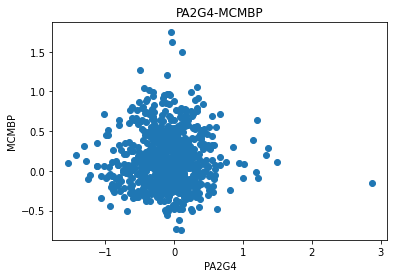

In [148]:
top_mon = mon_interventions["pairs_to_keep"][0]
print("ACE : {0}".format(str(round(mon_interventions["ace_pairs"][top_mon[0]], 2))))
print("LM Coef : {0}".format(str(round(mon_interventions["lm_coef"][top_mon[0]], 2))))

fig, ax = plt.subplots()
ax.scatter(mon[top_mon[0].split("-")[0]], mon[top_mon[0].split("-")[1]])
ax.set_title(top_mon[0])
ax.set_xlabel(top_mon[0].split("-")[0])
ax.set_ylabel(top_mon[0].split("-")[1])

#### Graph

In [296]:
S = y0_graph.subgraph([Variable('YY1'), Variable('HMGA1'), Variable('PRDM1'), 
                       Variable('NFKB1'), Variable('STAT1'), Variable('FOXO1'), 
                       Variable('HBP1'), Variable('SFN')])

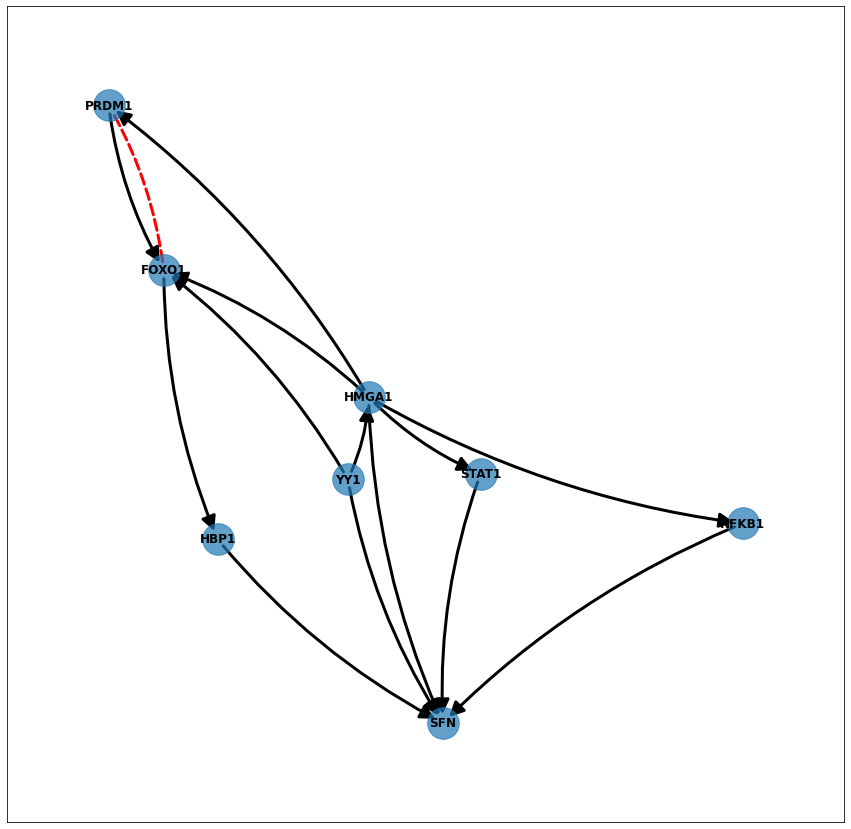

In [297]:
plot_latent_graph(S, figure_size=(15, 15))

In [221]:
y0_graph.undirected.edges

EdgeView([(FOXO1, SESN3), (FOXO1, CASP3), (FOXO1, RHOA), (FOXO1, BAX), (FOXO1, PRDM1), (CAT, NFKB1), (SOD2, NFKB1), (FH, STAT1), (FH, PRDM1), (CASP3, STAT1), (CASP3, HMGA1), (CASP3, NFKB1), (HMGB1, DNMT1), (HMGB1, NFKB1), (BAX, SOX9), (BAX, HMGA1), (STAT1, EIF2AK2), (STAT1, STMN1), (STAT1, HK2), (STAT1, PTPN13), (CDK2, HMGA1), (CYCS, HMGA1), (EIF2AK2, NFKB1), (PARP1, HMGA1), (SLC2A1, HMGA1), (STMN1, NFKB1), (TFAM, HMGA1), (TFAM, NFKB1), (HK2, HMGA1), (HK2, NFKB1), (FOXA2, VIM)])

In [231]:
undirect = list(y0_graph.undirected.edges)
for edge in list(S.edges()):
    for test in undirect:
        if (edge[0] == str(test[0])) & (edge[1] == str(test[1])):
            print(edge)
        elif (edge[1] == str(test[0])) & (edge[0] == str(test[1])):
            print(edge)
    

('HMGA1', 'CASP3')
('PRDM1', 'FOXO1')
('FOXO1', 'CASP3')
('NFKB1', 'CASP3')
('STAT1', 'CASP3')


In [228]:
list(S.edges())

[('HMGA1', 'FOXO1'),
 ('HMGA1', 'CASP3'),
 ('HMGA1', 'NFKB1'),
 ('HMGA1', 'PRDM1'),
 ('HMGA1', 'STAT1'),
 ('HMGA1', 'SFN'),
 ('PRDM1', 'FOXO1'),
 ('FOXO1', 'HBP1'),
 ('FOXO1', 'CASP3'),
 ('HBP1', 'CASP3'),
 ('HBP1', 'SFN'),
 ('NFKB1', 'CASP3'),
 ('NFKB1', 'SFN'),
 ('STAT1', 'CASP3'),
 ('STAT1', 'SFN'),
 ('YY1', 'CASP3'),
 ('YY1', 'FOXO1'),
 ('YY1', 'HMGA1'),
 ('YY1', 'SFN')]

In [225]:
list(y0_graph.undirected.edges)

[(FOXO1, SESN3),
 (FOXO1, CASP3),
 (FOXO1, RHOA),
 (FOXO1, BAX),
 (FOXO1, PRDM1),
 (CAT, NFKB1),
 (SOD2, NFKB1),
 (FH, STAT1),
 (FH, PRDM1),
 (CASP3, STAT1),
 (CASP3, HMGA1),
 (CASP3, NFKB1),
 (HMGB1, DNMT1),
 (HMGB1, NFKB1),
 (BAX, SOX9),
 (BAX, HMGA1),
 (STAT1, EIF2AK2),
 (STAT1, STMN1),
 (STAT1, HK2),
 (STAT1, PTPN13),
 (CDK2, HMGA1),
 (CYCS, HMGA1),
 (EIF2AK2, NFKB1),
 (PARP1, HMGA1),
 (SLC2A1, HMGA1),
 (STMN1, NFKB1),
 (TFAM, HMGA1),
 (TFAM, NFKB1),
 (HK2, HMGA1),
 (HK2, NFKB1),
 (FOXA2, VIM)]

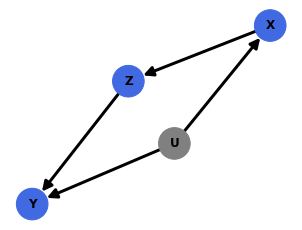

In [756]:
G = nx.DiGraph()
G.add_edge("X","Z")
G.add_edge("Z","Y")
G.add_edge("U","X")
G.add_edge("U","Y")
color_map = ["royalblue" if node != "U" else "grey" for node in G]
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

In [757]:
attrs = {node: (True if node == "U" else False) for node in ["X", "Z", "Y", "U"]}

In [758]:
attrs

{'X': False, 'Z': False, 'Y': False, 'U': True}

In [759]:
nx.set_node_attributes(G, attrs, name="hidden")

In [764]:
for node, data in G.nodes.items():
    print(data["hidden"])

False
False
False
True


##### Test identifiability

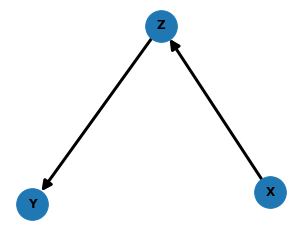

In [674]:
H = G.subgraph(["X", "Z", "Y"])
plt.figure(figsize=(4,3))
nx.draw(H, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000)
plt.show()

In [682]:
graph_builder(G, remove_latent_nodes(G, ["U"])).undirected.edges

EdgeView([])

In [194]:
y0_graph = NxMixedGraph.from_edges(
    directed=[
        (X, Z),
        (Z, Y),
    ],
    undirected=[
        (Y, X),

    ],
)
is_identifiable(y0_graph, P(Y @ X))

True

In [30]:
y0_graph.undirected.edges

EdgeView([(X, Y)])

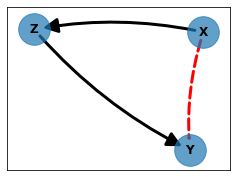

In [31]:
plot_latent_graph(y0_graph)

In [729]:
from y0.algorithm.simplify_latent import simplify_latent_dag
from y0.graph import NxMixedGraph

In [765]:
test = simplify_latent_dag(G, "hidden")

In [766]:
y0_graph = NxMixedGraph()

In [768]:
y0_graph = y0_graph.from_latent_variable_dag(test.graph, "hidden")

In [769]:
y0_graph.undirected.edges

EdgeView([(X, Y)])

In [742]:
for node, data in G.nodes.items():
    print(data["hidden"])

False
False
False
True


##### Confirm with SCM

In [293]:
U_data = np.random.normal(loc=0, scale=1, size=1000)
X_data = U_data + np.random.normal(loc=0, scale=1, size=1000)
Z_data = 3 * X_data + np.random.normal(loc=0, scale=1, size=1000)
Y_data = (2 * Z_data) + (3*U_data) + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X_data, Z=Z_data, Y=Y_data, U=U_data))

fit_scm(G, data, "X", "Y")

Fitting causal mechanism of node U: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 420.37it/s]


In [206]:
causal_model = gcm.StructuralCausalModel(H)
gcm.auto.assign_causal_mechanisms(causal_model, data)
gcm.fit(causal_model, data)

gcm.average_causal_effect(causal_model,
                         "Y",
                         interventions_alternative={"X": lambda y: 0, "Z": lambda x: 1},
                         interventions_reference={"X": lambda y: 0, "Z": lambda x: 0},
                         num_samples_to_draw=100000)

Fitting causal mechanism of node Y: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.21it/s]


In [156]:
U_data = 1
X_data = 1
Z_data = 0
Y_data = (2 * Z_data) + (3*U_data)

In [108]:
Y_data

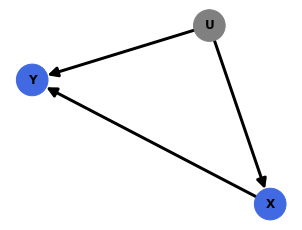

In [177]:
G = nx.DiGraph()
G.add_edge("X","Y")
G.add_edge("U","X")
G.add_edge("U","Y")
color_map = ["royalblue" if node != "U" else "grey" for node in G]
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True, font_weight='bold', arrowsize=20, width = 3, node_size=1000, node_color=color_map)
plt.show()

In [556]:
U_data = np.random.normal(loc=0, scale=1, size=1000)
X_data = U_data + np.random.normal(loc=0, scale=1, size=1000)
Z_data = 3 * X_data + np.random.normal(loc=0, scale=1, size=1000)
Y_data = (2 * Z_data) + (3*U_data) + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X_data, Z=Z_data, Y=Y_data))

G = nx.DiGraph()
G.add_edge("X","Z")
G.add_edge("Z","Y")
G.add_edge("U","X")
G.add_edge("U","Y")

fit_scm(G, data, "X", "Y")

KeyError: "None of [Index(['U'], dtype='object')] are in the [columns]"

In [ ]:
U_data = np.random.normal(loc=0, scale=1, size=100000)
X_data = U_data + np.random.normal(loc=0, scale=1, size=100000)
Y_data = (2 * X_data) + (3*U_data) + np.random.normal(loc=0, scale=1, size=100000)
data = pd.DataFrame(data=dict(X=X_data, U=U_data, Y=Y_data))

fit_scm(G, data, "X", "Y")

In [208]:
import stan

In [217]:
model_code = """
data {
  int<lower=0> N;         // number of obs
  vector[N] X;
  vector[N] Z;
  vector[N] Y;
}
parameters {
  real alpha_x;
  real sigma_x;
  real beta_z;
  real<lower=0> sigma_z;
  real beta_y;
  real<lower=0> sigma_y;
}
model {
  X ~ normal(alpha_x, sigma_x);
  Z ~ normal(beta_z * X, sigma_z);
  Y ~ normal(beta_y * Z, sigma_y);
}
"""

In [294]:
data = dict(N=100, X=X_data, Z=Z_data, Y=Y_data)

In [219]:
posterior = stan.build(model_code, data=data, random_seed=1)

RuntimeError: asyncio.run() cannot be called from a running event loop

In [9]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim

import torch
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO


In [3]:
def model(data=None):
    
    b_x = pyro.sample("b_x", dist.Normal(0., 1.))
    b_z = pyro.sample("b_z", dist.Normal(0., 1.))
    b_y = pyro.sample("b_y", dist.Normal(0., 1.))
    b_yu = pyro.sample("b_yu", dist.Normal(0., 1.))
    
    sigma_u = pyro.sample("sigma_u", dist.Uniform(0., 5.))
    sigma_x = pyro.sample("sigma_x", dist.Uniform(0., 5.))
    sigma_z = pyro.sample("sigma_z", dist.Uniform(0., 5.))
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0., 5.))
    
    if data is not None:
        with pyro.plate("data", len(data["X"])):
            latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))

            X = pyro.sample("X", dist.Normal(b_x*latent_u, sigma_x), obs=data["X"])
            Z = pyro.sample("Z", dist.Normal(X*b_z, sigma_z), obs=data["Z"])
            Y = pyro.sample("Y", dist.Normal(Z*b_y + latent_u*b_yu, sigma_y), obs=data["Y"])
    else:
        latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))
        X = pyro.sample("X", dist.Normal(latent_u, sigma_x))
        Z = pyro.sample("Z", dist.Normal(X*b_z, sigma_z))
        Y = pyro.sample("Y", dist.Normal(Z*b_y + latent_u*b_yu, sigma_y))
        
        return({'X': X,'Z': Z,'Y': Y})

In [4]:
def guide(data=None):

    b_x_loc = pyro.param('b_x_loc', torch.tensor(0.))
    # b_x_scale = pyro.param('b_x_scale', torch.tensor(1.))
    b_x = pyro.sample("b_x", dist.Normal(b_x_loc, .1))
    
    b_z_loc = pyro.param('b_z_loc', torch.tensor(0.))
    # b_z_scale = pyro.param('b_z_scale', torch.tensor(1.))
    b_z = pyro.sample("b_z", dist.Normal(b_z_loc, .1))
    
    b_y_loc = pyro.param('b_y_loc', torch.tensor(0.))
    # b_y_scale = pyro.param('b_y_scale', torch.tensor(1.))
    b_y = pyro.sample("b_y", dist.Normal(b_y_loc, .1))
    
    b_yu_loc = pyro.param('b_yu_loc', torch.tensor(0.))
    # b_yu_scale = pyro.param('b_yu_scale', torch.tensor(1.))
    b_yu = pyro.sample("b_yu", dist.Normal(b_yu_loc, .1))
    
    sigma_loc_u = pyro.param('sigma_loc_u', torch.tensor(1.), 
                           constraint=constraints.positive)
    sigma_u = pyro.sample("sigma_u", dist.Normal(sigma_loc_u, torch.tensor(0.05)))
    
    sigma_loc_x = pyro.param('sigma_loc_x', torch.tensor(1.), 
                           constraint=constraints.positive)
    sigma_x = pyro.sample("sigma_x", dist.Normal(sigma_loc_x, torch.tensor(0.05)))
    
    sigma_loc_z = pyro.param('sigma_loc_z', torch.tensor(1.), 
                           constraint=constraints.positive)
    sigma_z = pyro.sample("sigma_z", dist.Normal(sigma_loc_z, torch.tensor(0.05)))
    
    sigma_loc_y = pyro.param('sigma_loc_y', torch.tensor(1.), 
                           constraint=constraints.positive)
    sigma_y = pyro.sample("sigma_y", dist.Normal(sigma_loc_y, torch.tensor(0.05)))
    
    if data is not None:
        with pyro.plate("data", len(data["X"])):
            pyro.sample("latent_u", dist.Normal(0, sigma_u))
    else:
        latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))

In [42]:
def new_model(samples):
    U_data = np.random.normal(loc=0, scale=1, size=samples)
    X_data = U_data + np.random.normal(loc=0, scale=1, size=samples)
    Z_data = 3 * X_data + np.random.normal(loc=0, scale=1, size=samples)
    Y_data = (2 * Z_data) + (3*U_data) + np.random.normal(loc=0, scale=1, size=samples)

    data = dict(X=torch.tensor(X_data), 
                Z=torch.tensor(Z_data), 
                Y=torch.tensor(Y_data))
    
    svi = SVI(model,
          guide,
          optim.Adam({"lr": .001}),
          loss=Trace_ELBO())

    pyro.clear_param_store()
    for i in range(5000):
        elbo = svi.step(data)
    print(elbo)
    
    def inf_model():
    
        b_x = pyro.get_param_store()['b_x_loc'].detach()
        b_z = pyro.get_param_store()['b_z_loc'].detach()
        b_y = pyro.get_param_store()['b_y_loc'].detach()
        b_yu = pyro.get_param_store()['b_yu_loc'].detach()

        sigma_u = pyro.get_param_store()['sigma_loc_u'].detach()
        sigma_x = pyro.get_param_store()['sigma_loc_x'].detach()
        sigma_z = pyro.get_param_store()['sigma_loc_z'].detach()
        sigma_y = pyro.get_param_store()['sigma_loc_y'].detach()

        latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))
        X = pyro.sample("X", dist.Normal(latent_u*b_x, sigma_x))
        Z = pyro.sample("Z", dist.Normal(X*b_z, sigma_z))
        Y = pyro.sample("Y", dist.Normal(Z*b_y + latent_u*b_yu, sigma_y))

        return({'X': X,'Z': Z,'Y': Y})

    int_model1 = pyro.do(inf_model, data={'X': torch.tensor(1.)})
    Y_samples_1 = [int_model1()['Y'].detach().numpy() for _ in range(10000)]

    # int_model0 = pyro.do(inf_model, data={'X': torch.tensor(0.)})
    # Y_samples_0 = [int_model0()['Y'].detach().numpy() for _ in range(1000)]
    
    return Y_samples_1

In [49]:
U_data = np.random.normal(loc=0, scale=1, size=500)
X_data = U_data + np.random.normal(loc=0, scale=1, size=500)
Z_data = 3 * X_data + np.random.normal(loc=0, scale=1, size=500)
Y_data = (2 * Z_data) + (3*U_data) + np.random.normal(loc=0, scale=1, size=500)

data = dict(X=torch.tensor(X_data), 
            Z=torch.tensor(Z_data), 
            Y=torch.tensor(Y_data))

In [40]:
from pyro.infer import SVI, Trace_ELBO

svi = SVI(model,
          guide,
          optim.Adam({"lr": .001}),
          loss=Trace_ELBO())

pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(data)
    if i % 100 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 52674.40070869475
Elbo loss: 49896.655956427945
Elbo loss: 39771.95354833242
Elbo loss: 26771.79894063432
Elbo loss: 26735.23040397066
Elbo loss: 21035.187324353214
Elbo loss: 18006.81846554599
Elbo loss: 16011.216924199733
Elbo loss: 17161.434546840675
Elbo loss: 12351.879492496366
Elbo loss: 11771.31914181881
Elbo loss: 12885.30727932817
Elbo loss: 10475.567482199438
Elbo loss: 9955.009930595294
Elbo loss: 9384.165192061993
Elbo loss: 8255.264189425336
Elbo loss: 7951.065648579981
Elbo loss: 8142.139361237394
Elbo loss: 7010.23366380158
Elbo loss: 7038.6342453867255
Elbo loss: 6538.898561472584
Elbo loss: 6400.171042862608
Elbo loss: 5737.676485593136
Elbo loss: 6348.558323879035
Elbo loss: 5499.916441339277
Elbo loss: 5526.154828794014
Elbo loss: 5008.639261353624
Elbo loss: 5102.591290484332
Elbo loss: 4971.18827412188
Elbo loss: 4903.2139196067565
Elbo loss: 5119.645935321996
Elbo loss: 4633.153997120316
Elbo loss: 4608.356717469869
Elbo loss: 4435.109374342481
Elbo los

In [44]:
def inf_model():
    
    b_x = pyro.get_param_store()['b_x_loc'].detach()
    b_z = pyro.get_param_store()['b_z_loc'].detach()
    b_y = pyro.get_param_store()['b_y_loc'].detach()
    b_yu = pyro.get_param_store()['b_yu_loc'].detach()
    
    sigma_u = pyro.get_param_store()['sigma_loc_u'].detach()
    sigma_x = pyro.get_param_store()['sigma_loc_x'].detach()
    sigma_z = pyro.get_param_store()['sigma_loc_z'].detach()
    sigma_y = pyro.get_param_store()['sigma_loc_y'].detach()
    
    latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))
    X = pyro.sample("X", dist.Normal(latent_u, sigma_x))
    Z = pyro.sample("Z", dist.Normal(X*b_z, sigma_z))
    Y = pyro.sample("Y", dist.Normal(Z*b_y + latent_u*b_yu, sigma_y))

    return({'X': X,'Z': Z,'Y': Y})

In [45]:
pyro.get_param_store()['b_z_loc'].detach()

tensor(2.7611)

In [46]:
pyro.get_param_store()['b_y_loc'].detach()

tensor(2.0621)

In [47]:
int_model1 = pyro.do(inf_model, data={'X': torch.tensor(1.)})
Y_samples_1 = [int_model1()['Y'].detach().numpy() for _ in range(1000)]

int_model0 = pyro.do(inf_model, data={'X': torch.tensor(0.)})
Y_samples_0 = [int_model0()['Y'].detach().numpy() for _ in range(1000)]

In [48]:
np.mean(Y_samples_1)-np.mean(Y_samples_0)

5.8715844

(array([  4.,  19.,  77., 158., 227., 239., 152.,  84.,  31.,   9.]),
 array([-12.793955  , -10.227001  ,  -7.660048  ,  -5.0930943 ,
         -2.526141  ,   0.04081249,   2.607766  ,   5.1747193 ,
          7.741673  ,  10.308626  ,  12.87558   ], dtype=float32),
 <BarContainer object of 10 artists>)

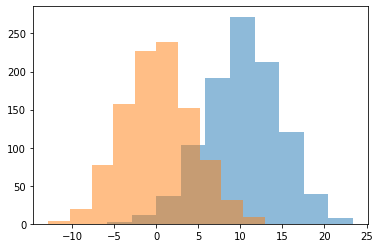

In [36]:
fig, ax = plt.subplots()
ax.hist(np.array(Y_samples_1), alpha=.5)
ax.hist(np.array(Y_samples_0), alpha=.5)

In [15]:
U_data = np.random.normal(loc=0, scale=1, size=10000)
X_data = 1.
Z_data = 3 * X_data + np.random.normal(loc=0, scale=1, size=10000)
Y_data = (2 * Z_data) + (3*U_data) + np.random.normal(loc=0, scale=1, size=10000)

gt_data = dict(X=torch.tensor(X_data), 
            Z=torch.tensor(Z_data), 
            Y=torch.tensor(Y_data))

<AxesSubplot:>

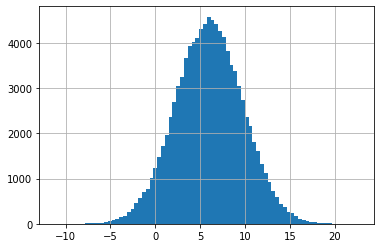

In [69]:
pd.Series(data["Y"].detach().numpy()).hist(bins=80)

In [30]:
int_samples10 = list()
for i in range(20):
    # try:
        int1 = new_model(10)
        int_samples10.append(int1)
    # except:
    #     print("{} failed".format(i))

77.85399873521706
78.48164304392539
82.32092237355721
75.41863879526491
81.33711613540154
79.07336323588012
87.26466092754745
75.06078451897903
89.71773059244765
75.79127231520789
97.37567658674064
88.79725637814603
86.03436794942535
97.61806493648636
89.1333817599077
84.56600437564903
87.62898218079577
84.68177134915398
92.83699822962186
73.81035055362617


In [12]:
import seaborn as sns

In [13]:
import matplotlib.pyplot as plt

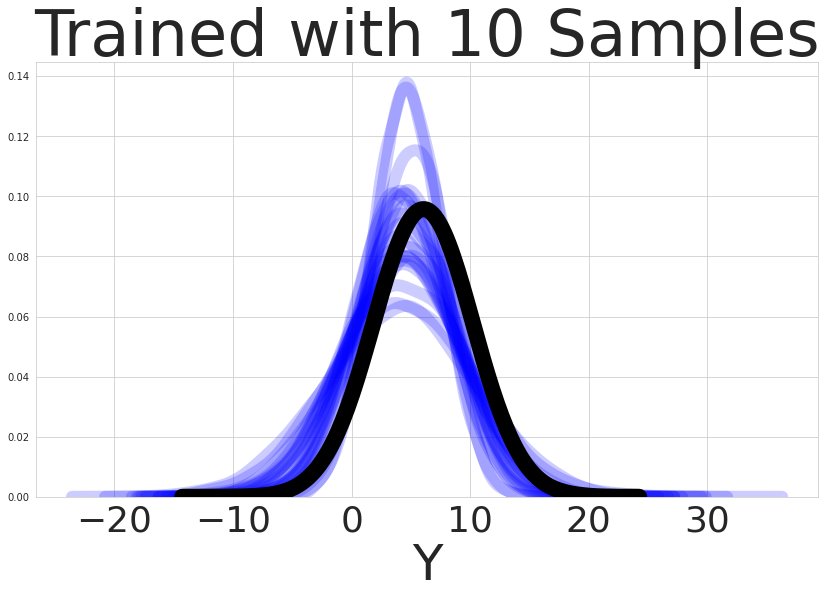

In [67]:
fig, ax = plt.subplots(figsize=(14,8))

sns.set_style('whitegrid')
for i in range(20):
    sns.kdeplot(np.array(int_samples10[i]), bw_method=0.2, ax=ax, color="blue", linewidth = 12, alpha=.2)
sns.kdeplot(gt_data["Y"].detach().numpy(), bw_method=0.5, ax=ax, color="black", linewidth = 16)
ax.set_title("Trained with 10 Samples", size=64)
ax.set_xlabel("Y", size=50)
ax.set_ylabel("")
ax.tick_params(axis='x', which='major', labelsize=36)

In [ ]:
int1_samples = list()

In [46]:
for i in range(7):
    # try:
        int1 = new_model(200)
        int1_samples.append(int1)
    # except:
    #     print("{} failed".format(i))

1171.4358790785968
1191.516408316925
1188.3027551835128
1190.8430304786002
1200.0085611159054
1230.3255871173399
1202.9876440306757


INFO: [2023-02-17 12:23:40] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:23:40] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:23:40] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:23:40] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:23:40] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:23:40] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:23:40] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:23:40] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

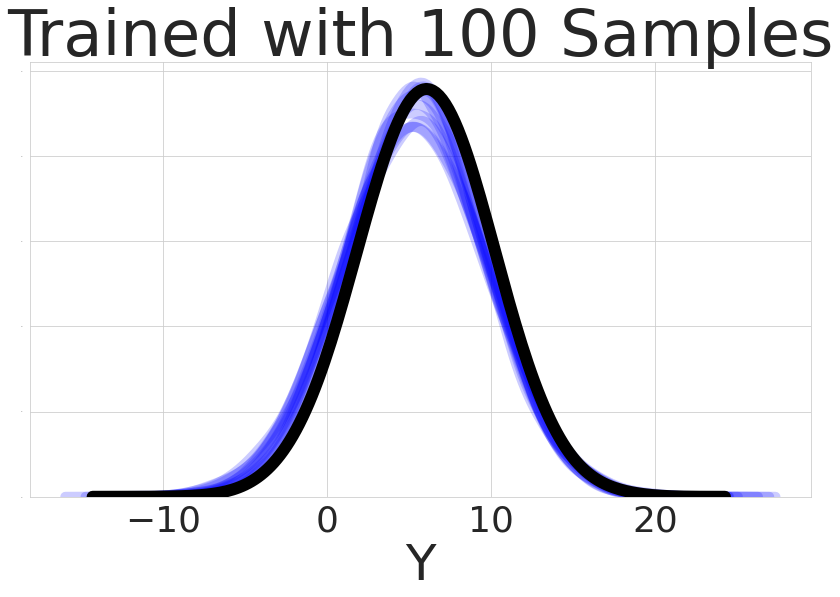

In [71]:
fig, ax = plt.subplots(figsize=(14,8))

sns.set_style('whitegrid')
for i in range(10):
    sns.kdeplot(np.array(int1_samples[i]), bw_method=0.2, ax=ax, color="blue", linewidth = 10, alpha=.2)
sns.kdeplot(gt_data["Y"].detach().numpy(), bw_method=0.5, ax=ax, color="black", linewidth = 12)
ax.set_title("Trained with 100 Samples", size=64)
ax.set_xlabel("Y", size=50)
ax.set_ylabel("")
ax.tick_params(axis='y', which='major', labelsize=0)
ax.tick_params(axis='x', which='major', labelsize=36)

In [53]:
def model(data=None):
    
    b_x = pyro.sample("b_x", dist.Normal(0., 1.))
    b_y = pyro.sample("b_y", dist.Normal(0., 1.))
    b_yu = pyro.sample("b_yu", dist.Normal(0., 1.))
    
    sigma_u = pyro.sample("sigma_u", dist.Uniform(0., 10.))
    sigma_x = pyro.sample("sigma_x", dist.Uniform(0., 10.))    
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0., 10.))
    
    if data is not None:
        with pyro.plate("data", len(data["X"])):
            latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))

            X = pyro.sample("X", dist.Normal(b_x*latent_u, sigma_x), obs=data["X"])
            Y = pyro.sample("Y", dist.Normal(X*b_y + latent_u*b_yu, sigma_y), obs=data["Y"])
    else:
        latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))
        X = pyro.sample("X", dist.Normal(latent_u, sigma_x))
        Y = pyro.sample("Y", dist.Normal(Z*b_y + latent_u*b_yu, sigma_y))
        
        return({'X': X,'Y': Y})
def guide(data=None):

    b_x_loc = pyro.param('b_x_loc', torch.tensor(0.))
    # b_x_scale = pyro.param('b_x_scale', torch.tensor(1.))
    b_x = pyro.sample("b_x", dist.Normal(b_x_loc, .1))
    
    b_y_loc = pyro.param('b_y_loc', torch.tensor(0.))
    # b_y_scale = pyro.param('b_y_scale', torch.tensor(1.))
    b_y = pyro.sample("b_y", dist.Normal(b_y_loc, .1))
    
    b_yu_loc = pyro.param('b_yu_loc', torch.tensor(0.))
    # b_yu_scale = pyro.param('b_yu_scale', torch.tensor(1.))
    b_yu = pyro.sample("b_yu", dist.Normal(b_yu_loc, .1))
    
    sigma_loc_u = pyro.param('sigma_loc_u', torch.tensor(1.), 
                           constraint=constraints.positive)
    sigma_u = pyro.sample("sigma_u", dist.Normal(sigma_loc_u, torch.tensor(0.05)))
    
    sigma_loc_x = pyro.param('sigma_loc_x', torch.tensor(1.), 
                           constraint=constraints.positive)
    sigma_x = pyro.sample("sigma_x", dist.Normal(sigma_loc_x, torch.tensor(0.05)))
    
    sigma_loc_y = pyro.param('sigma_loc_y', torch.tensor(1.), 
                           constraint=constraints.positive)
    sigma_y = pyro.sample("sigma_y", dist.Normal(sigma_loc_y, torch.tensor(0.05)))
    
    if data is not None:
        with pyro.plate("data", len(data["X"])):
            pyro.sample("latent_u", dist.Normal(0, sigma_u))
    else:
        latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))
def new_model(samples):
    U_data = np.random.normal(loc=0, scale=1, size=samples)
    X_data = U_data + np.random.normal(loc=0, scale=1, size=samples)
    Y_data = (6 * X_data) + (3*U_data) + np.random.normal(loc=0, scale=1, size=samples)

    data = dict(X=torch.tensor(X_data), 
                Y=torch.tensor(Y_data))
    
    svi = SVI(model,
          guide,
          optim.Adam({"lr": .001}),
          loss=Trace_ELBO())

    pyro.clear_param_store()
    for i in range(5000):
        elbo = svi.step(data)
    print(elbo)
    
    def inf_model():
    
        b_x = pyro.get_param_store()['b_x_loc'].detach()
        b_y = pyro.get_param_store()['b_y_loc'].detach()
        b_yu = pyro.get_param_store()['b_yu_loc'].detach()

        sigma_u = pyro.get_param_store()['sigma_loc_u'].detach()
        sigma_x = pyro.get_param_store()['sigma_loc_x'].detach()
        sigma_y = pyro.get_param_store()['sigma_loc_y'].detach()

        latent_u = pyro.sample("latent_u", dist.Normal(0, sigma_u))
        X = pyro.sample("X", dist.Normal(latent_u*b_x, sigma_x))
        Y = pyro.sample("Y", dist.Normal(X*b_y + latent_u*b_yu, sigma_y))

        return({'X': X,'Y': Y})
    
    int_model1 = pyro.do(inf_model, data={'X': torch.tensor(1.)})
    Y_samples_1 = [int_model1()['Y'].detach().numpy() for _ in range(1000)]
    
    return Y_samples_1

int_samples_confound = list()
for i in range(10):
    print(i)
    int_samples_confound.append(new_model(10))
int_samples100_confound = list()
for i in range(10):
    print(i)
    int_samples100_confound.append(new_model(200))

0
74.97634847943456
1
72.61206997950629
2
83.64400291184029
3
80.46460399558498
4
63.863057318242284
5
71.99598370517785
6
69.27251847853779
7
79.65156712509932
8
77.88512019670799
9
65.83899672059863
0
1104.7052787588073
1
1072.4370192758986
2
1099.1014548421138
3
1043.2428217850438
4
1067.0371055638025
5
1130.7240667227413
6
1088.9206119423604
7
1086.0993566392913
8
1061.5028033452718
9
1123.4938373965242


In [75]:
U_data = np.random.normal(loc=0, scale=1, size=1000)
X_data = 1.
# Z_data = 3 * X_data + np.random.normal(loc=0, scale=1, size=10000)
Y_data = (6 * X_data) + (3*U_data) + np.random.normal(loc=0, scale=1, size=1000)

new_gt_data = dict(X=torch.tensor(X_data), 
            Y=torch.tensor(Y_data))

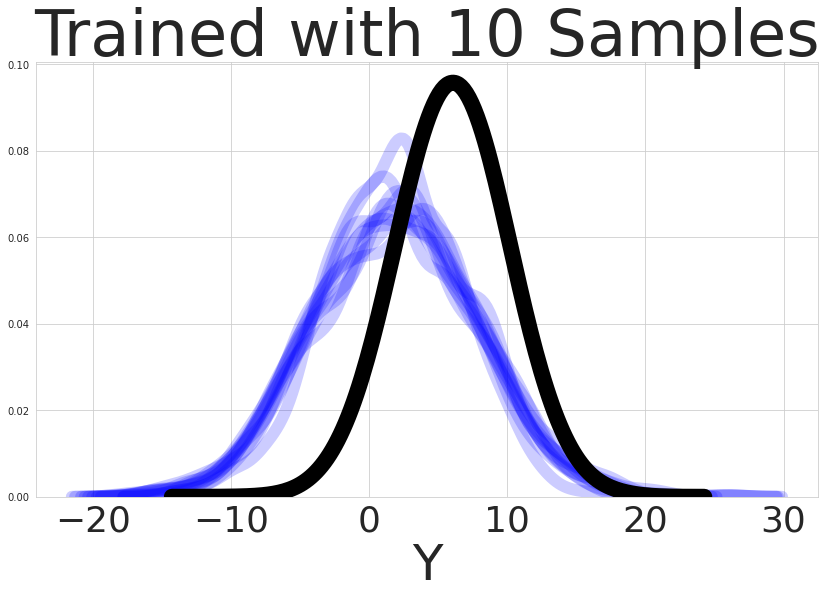

In [76]:
fig, ax = plt.subplots(figsize=(14,8))

sns.set_style('whitegrid')
for i in range(10):
    sns.kdeplot(np.array(int_samples_confound[i]), bw_method=0.2, ax=ax, color="blue", linewidth = 12, alpha=.2)
sns.kdeplot(gt_data["Y"].detach().numpy(), bw_method=0.5, ax=ax, color="black", linewidth = 16)
ax.set_title("Trained with 10 Samples", size=64)
ax.set_xlabel("Y", size=50)
ax.set_ylabel("")
ax.tick_params(axis='x', which='major', labelsize=36)

INFO: [2023-02-17 12:25:02] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:25:02] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:25:02] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:25:02] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:25:02] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:25:02] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:25:02] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO: [2023-02-17 12:25:02] matplotlib.font_manager - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

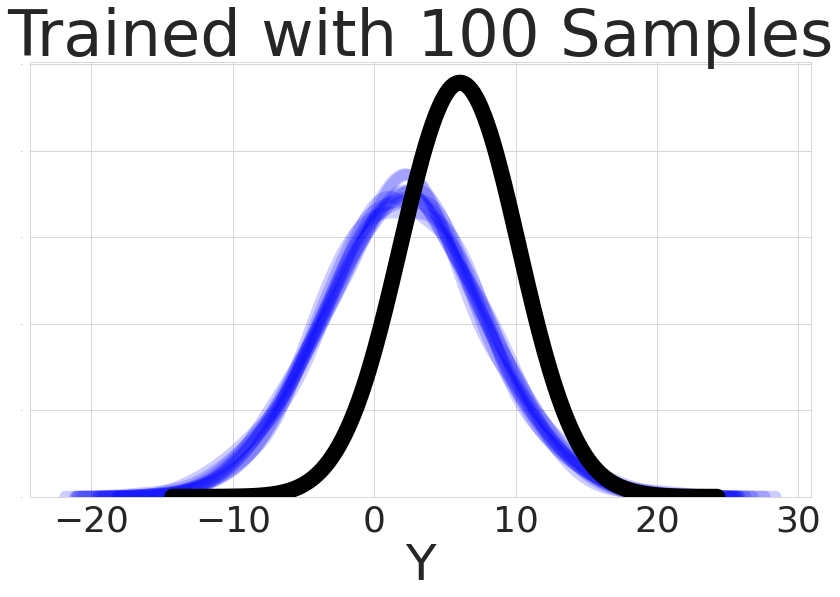

In [77]:
fig, ax = plt.subplots(figsize=(14,8))

sns.set_style('whitegrid')
for i in range(10):
    sns.kdeplot(np.array(int_samples100_confound[i]), bw_method=0.3, ax=ax, color="blue", linewidth = 12, alpha=.2)
sns.kdeplot(gt_data["Y"].detach().numpy(), bw_method=0.5, ax=ax, color="black", linewidth = 16)
ax.set_title("Trained with 100 Samples", size=64)
ax.set_xlabel("Y", size=50)
ax.set_ylabel("")
ax.tick_params(axis='y', which='major', labelsize=0)

ax.tick_params(axis='x', which='major', labelsize=36)